# Market Basket Analysis – Groceries Dataset

This notebook performs **Market Basket Analysis** using the **Apriori algorithm**.

Key points:
- Works with **Groceries dataset (single column, comma-separated items)**
- Bulletproof against kernel restarts
- Outputs are **visible** and also **saved** inside `output/`


## 1. Imports and folder setup

In [1]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from mlxtend.frequent_patterns import apriori, association_rules

folders = [
    "data/processed",
    "output",
    "output/visuals",
    "output/reports"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folders are ready.")


Folders are ready.


## 2. Load dataset

In [2]:
def load_raw_data():
    file_path = "data/raw/Online_retail.xlsx"
    if not os.path.exists(file_path):
        raise FileNotFoundError("Dataset not found in data/raw folder")

    df = pd.read_excel(file_path, engine="openpyxl")
    print("Dataset loaded successfully")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    return df

df_raw = load_raw_data()
display(df_raw.head())


Dataset loaded successfully
Shape: (7500, 1)
Columns: ['shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil']


,"shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil"
0,"burgers,meatballs,eggs"
1,chutney
2,"turkey,avocado"
3,"mineral water,milk,energy bar,whole wheat rice..."
4,low fat yogurt


## 3. Preprocess groceries dataset

In [3]:

def preprocess_data(df):
    col = df.columns[0]

    df = df.dropna(subset=[col])

    df["items"] = df[col].astype(str).apply(
        lambda x: [i.strip().lower() for i in x.split(",") if i.strip()]
    )

    df = df.drop(columns=[col])

    output_path = "data/processed/cleaned_groceries.csv"
    df.to_csv(output_path, index=False)

    print("Cleaned groceries saved to:", output_path)
    print("Total transactions:", len(df))

    return df

df_clean = preprocess_data(df_raw)
display(df_clean.head())


Cleaned groceries saved to: data/processed/cleaned_groceries.csv
Total transactions: 7500


,items
0,"[burgers, meatballs, eggs]"
1,[chutney]
2,"[turkey, avocado]"
3,"[mineral water, milk, energy bar, whole wheat ..."
4,[low fat yogurt]


## 4. Create basket format (SAFE)

In [4]:

def create_basket_format(df):
    if "items" not in df.columns:
        raise ValueError("Run preprocessing first")

    basket = df["items"].str.join("|").str.get_dummies(sep="|")

    output_path = "output/basket_format.csv"
    basket.to_csv(output_path, index=False)

    print("Basket saved to:", output_path)
    print("Basket shape:", basket.shape)

    return basket

basket = create_basket_format(df_clean)
display(basket.head())


Basket saved to: output/basket_format.csv
Basket shape: (7500, 119)


,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5. Apriori – Frequent itemsets

In [5]:

frequent_itemsets = apriori(
    basket,
    min_support=0.01,
    use_colnames=True
)

frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False)
frequent_itemsets.to_csv("output/frequent_itemsets.csv", index=False)

print("Total frequent itemsets:", len(frequent_itemsets))
display(frequent_itemsets.head())


c:\Users\pndin\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Total frequent itemsets: 259


,support,itemsets
46,0.238267,(mineral water)
19,0.179733,(eggs)
63,0.174133,(spaghetti)
24,0.170933,(french fries)
13,0.163867,(chocolate)


## 6. Generate association rules

In [6]:

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.2
)

rules = rules[rules["lift"] >= 1.0]
rules = rules.sort_values(by="lift", ascending=False)

rules.to_csv("output/association_rules.csv", index=False)
rules.head(20).to_csv("output/top_rules.csv", index=False)

print("Total rules generated:", len(rules))
display(rules.head())


Total rules generated: 160


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
84,(herb & pepper),(ground beef),0.049467,0.098267,0.016000,0.323450,3.291555,1.0,0.011139,1.332841,0.732423,0.121457,0.249723,0.243136
70,"(mineral water, spaghetti)",(ground beef),0.059733,0.098267,0.017067,0.285714,2.907540,1.0,0.011197,1.262427,0.697745,0.121097,0.207875,0.229696
83,(tomatoes),(frozen vegetables),0.068400,0.095333,0.016133,0.235867,2.474134,1.0,0.009613,1.183913,0.639564,0.109304,0.155344,0.202549
77,(shrimp),(frozen vegetables),0.071333,0.095333,0.016667,0.233645,2.450820,1.0,0.009866,1.180480,0.637444,0.111111,0.152887,0.204235
135,"(mineral water, milk)",(frozen vegetables),0.048000,0.095333,0.011067,0.230556,2.418415,1.0,0.006491,1.175740,0.616078,0.083669,0.149472,0.173320


## 7. Rule analysis and visualizations

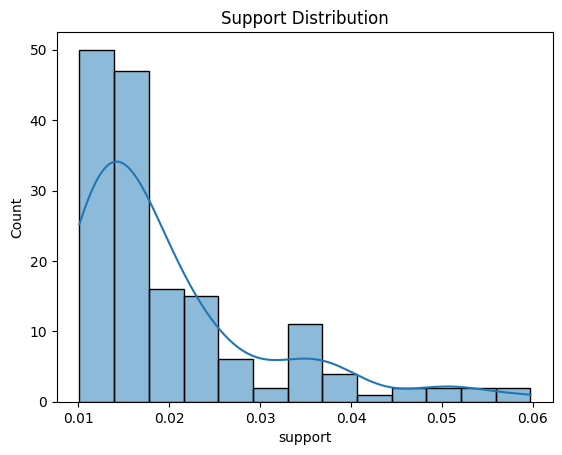

[INFO] Saved: output/visuals/support_distribution.png


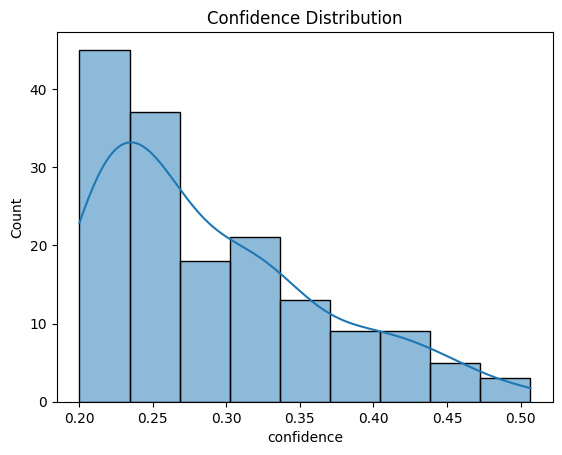

[INFO] Saved: output/visuals/confidence_distribution.png


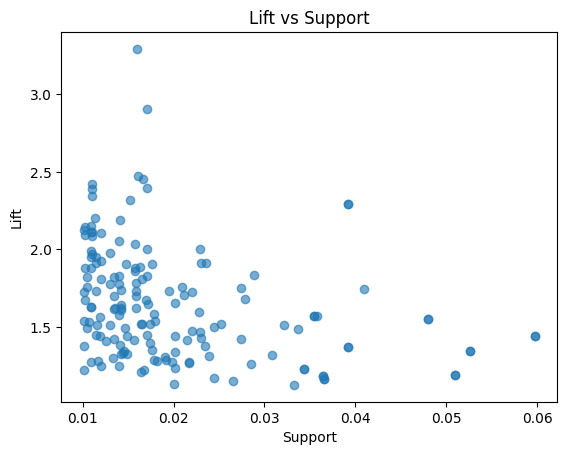

[INFO] Saved: output/visuals/lift_vs_support.png


In [7]:
import os
os.makedirs("output/visuals", exist_ok=True)

# -----------------------------
# SUPPORT DISTRIBUTION
# -----------------------------
plt.figure()
sns.histplot(rules["support"], kde=True)
plt.title("Support Distribution")

support_path = "output/visuals/support_distribution.png"
plt.savefig(support_path, bbox_inches="tight")
plt.show()

print("[INFO] Saved:", support_path)


# -----------------------------
# CONFIDENCE DISTRIBUTION
# -----------------------------
plt.figure()
sns.histplot(rules["confidence"], kde=True)
plt.title("Confidence Distribution")

confidence_path = "output/visuals/confidence_distribution.png"
plt.savefig(confidence_path, bbox_inches="tight")
plt.show()

print("[INFO] Saved:", confidence_path)


# -----------------------------
# LIFT vs SUPPORT
# -----------------------------
plt.figure()
plt.scatter(rules["support"], rules["lift"], alpha=0.6)
plt.title("Lift vs Support")
plt.xlabel("Support")
plt.ylabel("Lift")

lift_path = "output/visuals/lift_vs_support.png"
plt.savefig(lift_path, bbox_inches="tight")
plt.show()

print("[INFO] Saved:", lift_path)


## 8. Network graph

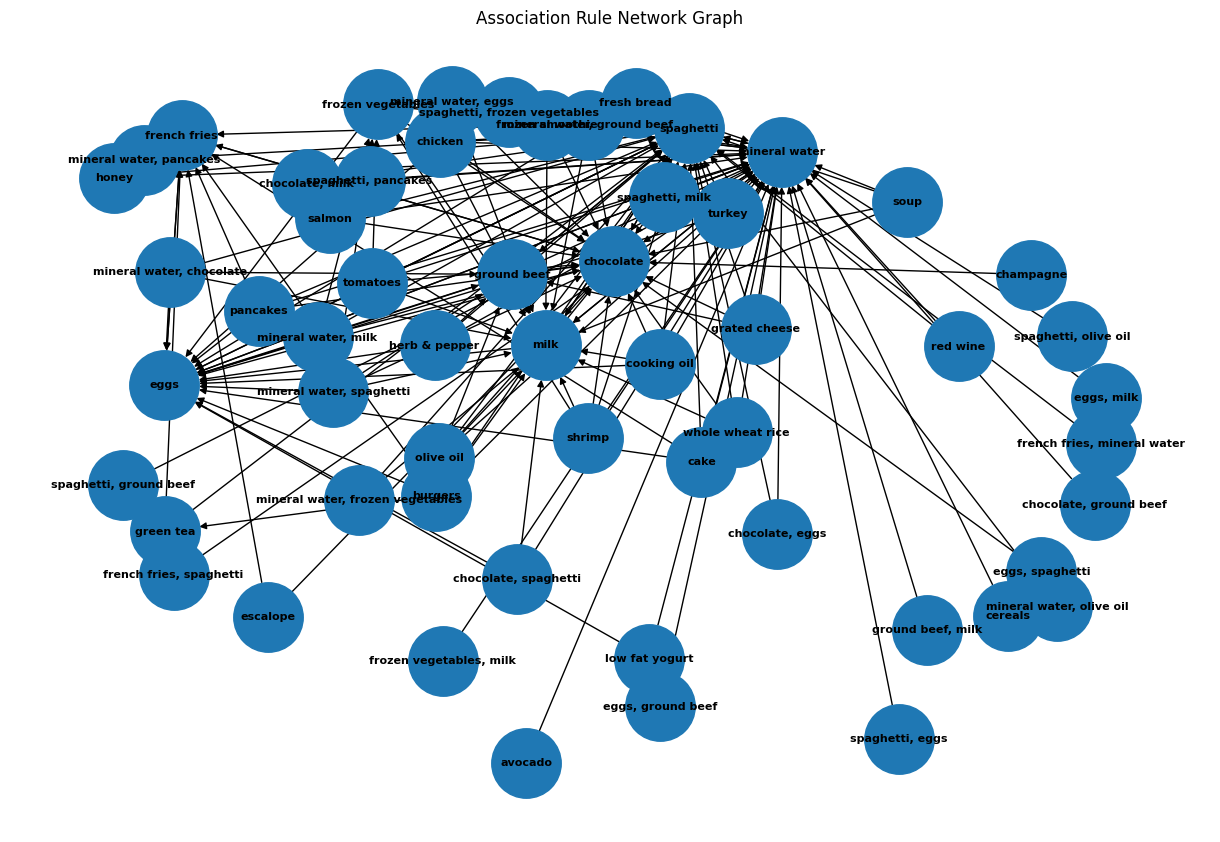

[INFO] Network graph saved at: output/visuals/network_graph.png


In [8]:
# Make sure output folder exists
import os
os.makedirs("output/visuals", exist_ok=True)

# Create directed graph
graph = nx.DiGraph()

for _, row in rules.iterrows():
    left = ', '.join(list(row['antecedents']))
    right = ', '.join(list(row['consequents']))
    graph.add_edge(left, right, weight=row['lift'])

# Draw graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph, k=1)

nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=2500,
    font_size=8,
    font_weight="bold"
)

plt.title("Association Rule Network Graph")

# ✅ SAVE first
save_path = "output/visuals/network_graph.png"
plt.savefig(save_path, bbox_inches="tight")

# ✅ THEN show
plt.show()

print("[INFO] Network graph saved at:", save_path)


## 9. Final report

In [9]:

strongest_rule = rules.iloc[0]

with open("output/reports/final_report.txt", "w") as f:
    f.write("MARKET BASKET ANALYSIS REPORT\n")
    f.write("=============================\n\n")
    f.write(f"Total Rules: {len(rules)}\n")
    f.write(f"Strongest Rule: {list(strongest_rule['antecedents'])} -> {list(strongest_rule['consequents'])}\n")
    f.write(f"Lift: {strongest_rule['lift']:.3f}\n")
    f.write(f"Confidence: {strongest_rule['confidence']:.3f}\n")

print("Final report saved to output/reports/final_report.txt")


Final report saved to output/reports/final_report.txt


## Conclusion

This project demonstrates how Apriori can be used to find frequent
item combinations in groceries data. The results help understand
customer purchasing behavior.